# **Lab 3: Logistic Regression and Decision Tree**

CS 412, Introduction to Machine Learning

Department of Computer Science, University of Illinois at Chicago

***This is a group work for at most four students.***

This is your third lab work, and you will work on it with your teammates. You will learn how to apply the logistic regression model to recognize images of hand-written digits. You will also learn how to build a decision tree to visually and explicitly represent decision making. 

***Deadline:***
This assignment is due **Nov 20** (Anywhere on Earth, [AoE](https://www.timeanddate.com/time/zones/aoe)). That is, you can resubmit as often as you like provided that anywhere on Earth is still on or before this date. 

***How to submit:***
See bottom of the page

***Python version:***
The code should work on Python 3.7 or later, though it might work on earlier versions (not tested). There should be no version problem if you work on Colab.  If you use Colab, ignore the following message when you open the notebook (if it shows up): \\
`Unrecognized runtime "python_defaultSpec_1600651579462"; defaulting to "python3"`

See a more detailed introduction to Python and Colab at this [link](https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb#scrollTo=nxvEkGXPM3Xh).  You may also find the setup instructions useful [here](https://cs231n.github.io/setup-instructions/).  Here are summaries that compare Matlab with Numpy: [link-1](https://numpy.org/doc/stable/user/numpy-for-matlab-users.html), [link-2](https://realpython.com/matlab-vs-python/).

**Please note before starting the lab:**

1. If you use Colab, copy this file to your own Google Drive so that you can edit it or share it with your teammates.

2. Since the experiments involve randomness, it is important to ensure that your results are replicable. To this end, your implementation should take one integer (or any numeric value) as a seed that is used to initialize the random number generators.
See, e.g. [random.seed](https://docs.python.org/3/library/random.html).
This has been done for you in the first code block below.

3. <font color='red'> There are unit test cases provided after each function you need to implement. Make good use of them.</font>  In the logistic regression part, it is fine if your result is within 1% relative difference from the reference result.  In the decision tree part, your result should be exactly the same as the reference result, except the `gini_score` function where 1% relative difference will be fine.

4. The label $y^i$ used in this lab corresponds to $r^t$ in the lecture slides.  It is far more common to denote the ground truth label by $y$.

In [ ]:
# Let's first import some modules for this experiment
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

#Problem 1: Logistic Regression {-}

In this problem, we will implement a Logistic Regression model with gradient descent from scratch. Logistic regression is a statistical model used for binary classification. We start with the fundamental mathematics and statistics behind logistic regression, and then extend it to multinomial logistic regression which can handle multi-class classification problems. To help you fully understand how they work, we will be working on a real dataset to recognize images of hand-written digits.

## 1.1 From linear regression to logistic regression {-}

In our previous lab assignment, we have learned how to use linear regression to predict the quality of wines. Actually linear regression is one of the most extensively used statistical technique for predictive modelling analysis thanks to its simplicity. Let us take a quick review of this method.

### 1.1.1 Recap of linear regression {-}

Linear regression assumes that the dependence of the target $y$ on the features $x_1, ..., x_m$ is linear, even if the true regression function is nonlinear. One benefit of making a linear dependence assumption is that the relationship between the target and features can be easily interpreted.

Let's define $f_w(x)$ as the hypothesis for $y$ as a function of $x\in\mathbb{R}^m$, under the weight vector $w\in\mathbb{R}^m$.  This results in the following prediction function:
$$f_w(x) = x^Tw.$$
Our goal is to find the optimal $w$ that maps $f_w(x)$ to $y$ as accurately as possible. To achieve that, we use gradient descent to minimize the squared loss as the cost function:
$$L(w) = \frac{1}{2}||x^Tw - y||^2.$$
Once we have learned the optimal $w$ from training data, we can use the learned model to predict the real value for test examples. 

In essence, linear regression is predicting continuous variables instead of binary variables. Then a natural question is whether linear regression can be used to solve classification problems. The answer is affirmative. Considering a binary classification problem, one can set up a threshold to distinguish different categories. Say if the predicted continuous value is greater than the threshold value, the data point will be classified as positive. Otherwise, it will be classified as negative. However, these predictions are not sensible for classification because the predicted values range from $-\infty$ to $\infty$ which can lead to adverse consequences in real-time. As a result, logistic regression comes to play.

### 1.1.2 Logistic Regression - Modeling **(4 points)** {-}

The basic idea of logistic regression is to produce probabilities out of linear regression. To achieve this, it feeds the learned score $x^Tw$ into a non-linear transformation, which is known as a sigmoid function:
$$\sigma(z) = \frac{1}{1+e^{-z}}.$$
Note that the sigmoid function $\sigma(z)$ transforms an unbounded real number $z$ into the interval [0,1]:
$$
\begin{align}
&\sigma(z) \rightarrow 1, \quad as \quad z \rightarrow \infty\\
&\sigma(0) = \frac{1}{2}, \\
&\sigma(z) \rightarrow 0, \quad as \quad  z \rightarrow -\infty.
\end{align}
$$
Moreover, $\sigma(z)$ is differentiable and its derivative has a nice property
for convenient computation
\begin{align}
\sigma'(z) &= -\frac{1}{(1+e^{-z})^2}(-e^{-z}) \\
&= \frac{1}{1+e^{-z}}\frac{e^{-z}}{1+e^{-z}} \\
&= \frac{1}{1+e^{-z}}(1 - \frac{1}{1+e^{-z}}) \\
&=\sigma(z)(1-\sigma(z)).
\end{align}

As we can see, if we modify $f_w$ to
$$f_w(x) = \sigma(x^Tw),$$
then we have a model that outputs probabilities of an example $x$ belonging to the positive class, or in a mathematical form:
$$P(y=1|x;w) = \frac{1}{1+e^{-x^Tw}}$$
For the negative class we have
$$P(y=0|x;w) = \frac{e^{-x^Tw}}{1+e^{-x^Tw}} = 1 - P(y=1|x;w)$$
At training time, we learn the value of $w$ to yield high values for $P(y=1|x;w)$ when $x$ is a positive example, and to yield low values for $P(y=0|x;w)$ when $x$ is a negative example. 

In practice, a real dataset contains many training examples. To make the computation efficient, in this experiment, we will process all data points at once instead of one at a time. Let's assume the dataset contains $n$ examples  which allows us to assemble a feature matrix $X =[x^1, x^2, ..., x^n]^T \in\mathbb{R}^{n\times m}$, 
where $x^i$ represents the $i$-th training example, and $^T$ is matrix transpose.
Then the prediction can be written as
$$\begin{pmatrix} P(y=1|x^1;w) \\ \vdots \\ P(y=1|x^n; w)\end{pmatrix} = \frac{1}{1+e^{-Xw}},$$
where $Xw$ leads to an $n$-dimensional vector,
and all other operations on the right-hand side (e.g., exponentiation and reciprocal) are performed elementwise on a vector.

In the following code block, implement the functions `sigmoid` and `logistic_regression` that can handle *batch* inputs (see the header of the functions and the unit tests).

In [ ]:
def sigmoid(z):
  """
  sigmoid function that maps inputs into the interval [0,1]
  Your implementation must be able to handle the case when z is a vector (see unit test)
  Inputs:
  - z: a scalar (real number) or a vector
  Outputs:
  - trans_z: the same shape as z, with sigmoid applied to each element of z
  """
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  trans_z = 1 / (1 + np.exp(-z))

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return trans_z

def logistic_regression(X, w):
  """
  logistic regression model that outputs probabilities of positive examples
  Inputs:
  - X: an array of shape (num_sample, num_features)
  - w: an array of shape (num_features,)
  Outputs:
  - logits: a vector of shape (num_samples,)
  """
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  logits = sigmoid(X.dot(w))

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return logits

# unit test
# sample inputs:
z = np.array([215, -108, 0, 0.32])
X = np.array([[4.17022005e-01, 7.20324493e-01, 1.14374817e-04],
               [3.02332573e-01, 1.46755891e-01, 9.23385948e-02],
               [1.86260211e-01, 3.45560727e-01, 3.96767474e-01],
               [5.38816734e-01, 4.19194514e-01, 6.85219500e-01]])
w = np.array([0.20445225, 0.87811744, 0.02738759])

# sample outputs:
out1 = sigmoid(z)
print(out1)
# out1 : [1.00000000e+00 1.24794646e-47 5.00000000e-01 5.79324252e-01]
out2 = logistic_regression(X, w)
print(out2)
# out2 : [0.67212099 0.5481529  0.5871972  0.62176131]


[1.00000000e+00 1.24794646e-47 5.00000000e-01 5.79324252e-01]
[0.67212099 0.5481529  0.5871972  0.62176131]


### 1.1.3 Loss function **(8 points)** {-}
Recall that in linear regression, we optimize the model by minimizing the square loss:
$$L(w) = \frac{1}{2}||x^Tw - y||^2$$
This loss is a convex function w.r.t $w$, hence the local minimum is also the global minimum.

A naive way to extend linear regression to classification would be to use the loss $\frac{1}{2}||\sigma(x^Tw) - y||^2$, where $y$ is either 1 or 0 (for positive or negative, respectively).  This loss turns out very hard to optimize with an algorithm like gradient descent, because the loss function is not convex in $w$. In other words, there can be more than one local minimum and we wouldn't be assured to find the global minimum that best optimizes the loss.

Instead of minimizing the square error as in the linear regression, we can resort to maximizing the likelihood of the training set as in many other machine learning algorithms. By making the standard assumption that training examples are generated independently, the likelihood function is given by
$$
\begin{align}
L(w) &= P(y^1, ..., y^n|x^1, ..., x^n; w) \\
&= \prod_{i=1}^n P(y^i|x^i;w)\\
&= \prod_{i=1}^n (\sigma(w^T x^i))^{y^i}(1-\sigma(w^T x^i))^{1-y^i}.
\end{align}
$$

To see the last step, just enumerate the two cases of $y^i = 1$ or $0$ since we are considering a binary classification problem.
To simplify the computation, let us maximize the logarithm of the likelihood,
which is equivalent to minimizing $-\frac{1}{n}$ times the log-likelihood:
$$
\begin{align}
\ell(w) &= -\frac{1}{n}\log \prod_{i=1}^n (\sigma(w^T x^i))^{y^i}(1-\sigma(w^T x^i))^{1-y^i} \\
\tag{1}
&= \frac{1}{n}\sum_{i=1}^n \left[-{y^i}\log(\sigma(w^T x^i)) - (1-y^i)\log(1-\sigma(w^T x^i))\right].
\end{align}
$$

The term inside the square bracket is generally referred to as cross-entropy loss, or logistic loss.
That is, for a given data point $\{x, y\}$,
it can be written as two cases: 
\begin{align}
\ell(x; w) &= 
\tag{2}
-{y}\log(\sigma(w^T x)) - (1-y)\log(1-\sigma(w^T x)) \\
\tag{3}
&= \begin{cases}
-\log(1-\sigma(x^Tw)) & \text{if } y=0\\
-\log(\sigma(x^Tw))    & \text{if } y=1\\
\end{cases}.
\end{align}

In practice, we surely implement Eq 3 based on the value of $y$.
Eq 2, however, gives more convenience in mathematical derivation as it unifies two cases neatly.
If we plot the curve of $\ell(x; w)$ as a function of $w$, we will see it is a convex function and therefore the gradient descent algorithm can find its global minima. Just like in linear regression, we will use the derivative of the loss function to calculate a gradient descent step. Please derive 

1. The gradient of $\ell(x; w)$ in Eq 2 with respect to (w.r.t.) $w$. 
<font color='red'> Fill your solution in the following line </font>: 

$$\nabla_w\ell(x;) = (y-\sigma(w^T x))x$$ 


2. the gradient of $\ell(w)$ in Eq 1 w.r.t. $w$.  For computational efficiency, we would like to express it in terms of two the feature matrix $X = (x^1, x^2, ..., x^n)^T \in\mathbb{R}^{n\times m}$ and the label vector $Y = (y^1, y^2, ..., y^n)\in\mathbb{R}^n$).  <font color='red'> Fill your solution in the following line </font>:

$$\nabla_w\ell(w) = (1/n)*X^T\cdot (Y-\sigma(X\cdot W))$$ 

Then, implement a function `logistic_loss` that computes $\ell(w)$ and the gradient in $w$.


In [ ]:
def logistic_loss(X, w, y):
  """
  a function that compute the loss value for the given dataset (X, y) and parameter w;
  It also returns the gradient of loss function w.r.t w
  Here (X, y) can be a set of examples, not just one example.
  Inputs:
  - X: an array of shape (num_sample, num_features)
  - w: an array of shape (num_features,)
  - y: an array of shape (num_sample,), it is the ground truth label of data X
  Output:
  - loss: a scalar which is the value of loss function for the given data and parameters
  - grad: an array of shape (num_featues,), the gradient of loss 
  """
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  logits = logistic_regression(X, w)
  loss = -y * np.log(logits) - (1 - y) * np.log(1 - logits)
  loss = np.average(loss)

  dsigmoid = X * (logits * (1 - logits)).reshape(-1, 1)
  y = y.reshape(-1, 1)
  
  num_samples = X.shape[0]
  grad = np.zeros(X.shape)
  for i in range(num_samples):
    grad[i] = -y[i] * dsigmoid[i] / logits[i] + (1 - y[i]) * dsigmoid[i] / (1 - logits[i])
  grad = np.average(grad, axis = 0)

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return loss, grad
#unit test
# inputs:
X = np.array([[0.67046751, 0.41730480, 0.55868983],
               [0.14038694, 0.19810149, 0.80074457],
               [0.96826158, 0.31342418, 0.69232262],
               [0.87638915, 0.89460666, 0.08504421]])
w = np.array([0.03905478, 0.16983042, 0.8781425 ])
Y = np.array([1, 1, 0, 1])

# sample outputs:
loss, grad = logistic_loss(X, w, Y)
print(loss)
print(grad)
# loss: 0.626238298577102
# grad: [-0.00483685, -0.09821878, -0.0080873 ]


0.626238298577102
[-0.00483685 -0.09821878 -0.0080873 ]


## 1.2 Recognizing hand-written digits with logistic regression {-}

We have gone through all the theoretical concepts of the logistic regression model. It's time to put hands on a real problem in which we aim to recognize images of hand-written digits. The dataset we will use is the Optical Recognition of Handwritten Digits dataset, and the description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). 

### 1.2.1 Data preprocessing (not for grading){-}
The original dataset contains 10 classes (digits 0 to 9). Since for now we are concerned about logistic regression for binary classification, we will only use a subset of the dataset that contains 360 examples from 2 classes (digits 0 and 1).  Each example is a $8\times 8$ matrix (image) where each element is an integer in the range $[0,16]$. Let's load the dataset by using the off-the-shell method from `sklearn` and print out some images to get a good understanding of the dataset.

In [ ]:
# set up the code for this experiment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

%matplotlib inline
np.random.seed(1)

# load the digits dataset
digits = load_digits(n_class=2)
# digits is a dictionary-like object that hold all the features and labels,
# along with some metadata about the dataset. 
# The features are stored in the '.data' member, a (#sample, #feature) array. 
# The labels are stored in the '.target' member.

print(f'There are {len(digits.target)} examples in total.')
print(f'All examples are images of hand-written digit {list(set(digits.target))[0]} \\
        or hand-written digits {list(set(digits.target))[1]}')
print(f'Each example is an array of shape {digits.data[0].shape}')
print(f'An example of data point:\n{digits.data[0]}')

# You may wondering why the shape of data is (64,) instead of (8, 8). Actually,
# You can access to matrix shape of data through the '.images' member.
print(f'The shape of image is {digits.images[0].shape}') 
print(f'An example of 2D array data:\n {digits.images[0]}')

There are 360 examples in total.
All examples are images of hand-written digit 0 \        or hand-written digits 1
Each example is an array of shape (64,)
An example of data point:
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
The shape of image is (8, 8)
An example of 2D array data:
 [[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


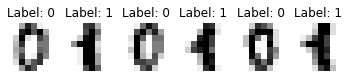

In [ ]:
# The data we are interested in is made up of 8x8 images of digits. 
# Let's have a look at the first 6 images that are drawn from the dataset. 
# For these images, 
#   we know the digit they represented is given in the 'target' of the dataset.
_, axes = plt.subplots(1, 6)
img_label = list(zip(digits.images, digits.target))
for ax, (img, target) in zip(axes, img_label[:6]):
  ax.set_axis_off()
  ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
  ax.set_title('Label: %i' % target)
plt.show()

### 1.2.2 Padding features (not for grading) {-}
As we did in Lab 2, to simplify the notation, we pad the input $x$ by inserting 1 to the **beginning** so that we can absorb the bias term into the parameter $w$.

The following code morphs the variable `digits.data` by concatenating 1 and features.

In [ ]:
ones = np.ones(digits.data.shape[0]).reshape(-1, 1)
digits.data = np.concatenate((ones, digits.data), axis=1)
print(digits.data.shape)

(360, 65)


### 1.2.3 Create training and test sets (not for grading) {-}
As we have practiced in our previous lab assignment, we will use the `train_test_split()` method to partition the dataset into training and test sets. In this experiment, we use 80% data for training and the remaining 20% data for testing. To ensure your results are replicable, we will set the `random_state` argument of `train_test_split()` to **1**.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, train_size=0.8, random_state=1)
print(f'The training set contains {X_train.shape[0]} examples.')
print(f'The testing set contains {X_test.shape[0]} examples.')

The training set contains 288 examples.
The testing set contains 72 examples.


### 1.2.3 Feature Normalization (not for grading) {-}
In the previous lab assignment, we have implemented the function `featureNormalization()` to normalize the features that have different scale. In this lab, we will learn to use the built-in function `StandardScaler()` in `scikit-learn`. As we did in `featureNormalization()`, `StandardScaler()` returns standardized features by removing the mean and scaling to unit variance.
Please read through the [API documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for detailed instructions.

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### 1.2.5 Training the model with gradient descent **(13 points)**{-}
Now after all the pre-processing, we can train a logisitic regression model with the training data.  It is quite straightforward to make predictions on test data by using the learned model. To simplify the task, when the probability of being positive is greater than 0.5, we classify the sample to 1. Otherwise, we classify it to 0.

In this part, we will train the model with gradient descent. After that, predict the label for test examples and compute the test accuracy. You may want to follow the procedures below to obtain the results:
+ Randomly initialize the parameter $w$ by `np.random.rand`.
+ Use gradient descent to update $w$ (number of iteration `num_iters` and learning rate `lr` are provided).
+ Plot the curve of the $\ell(w)$ value as a function of how many update steps have been taken (you need a variable to store the history of $\ell(w)$ values).
+ Compute and report the test accuracy on test set.

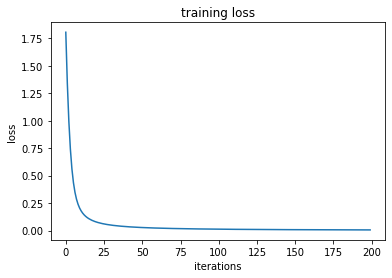

Test accuracy is 97.22222222222221%


In [ ]:
num_iters = 200
lr = 0.1

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****






















num_feats = X_train[0].shape[0]
num_tests = y_test.shape[0]

w = np.random.rand(num_feats)
losses = []

# training
for i in range(num_iters):
  loss, grad = logistic_loss(X_train, w, y_train)
  losses.append(loss)
  w -= (grad * lr)

# plotting
plt.plot(range(num_iters), losses)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.title('training loss')
plt.show()

# testing
probs = logistic_regression(X_test, w)
num_correct = 0
for i in range(num_tests):
  y_pred = 0
  if probs[i] > 0.5:
    y_pred = 1
  if y_pred == y_test[i]:
    num_correct += 1
print(f"Test accuracy is {num_correct / num_tests * 100}%")



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

## 1.3 Multinomial (multi-class) Logistic Regression (MLR) {-}

So far we have built a logisitic regression model for binary classification. In this section, we aim to extend it to multinomial logistic regression for solving multi-class classification. More specifically, we expect the MLR model can predict one out of $k$ possible classes, where $k$ is the total number of classes. 

Recall that in binary logisitic regression, the output of the model is the probability of the positive class. Analogously, the MLR model should perform a series of mathematical operations to produce a vector encoding the probability that an example $x$ belongs to each class:
\begin{align}
\begin{pmatrix}
  P(y=1|x; W) \\
  \vdots \\
  p(y=k|x; W)
\end{pmatrix},
\quad where \quad
W = (w_1, \ldots, w_k).
\end{align}

Here $w_1, \ldots, w_k$ are all $m$-dimensional vectors, one for each class.
$W$ is an $m$-by-$k$ matrix.
The class with the highest probability will be adopted as the prediction outcome for the given data $x$. 
Now the question is, how does the MLR model covert features to probability values? In binary logistic regression, we used the sigmoid function. 
In MLR, we can use the `softmax` to covert $(w_1^T x, \ldots, w_k^T x)$ (which are often called logits) to probability values. 
For a $k$-class problem, this conversion formula is 
$$
P(y=i|x; W) = \frac{e^{w_i^Tx}}{\sum_{j=1}^k e^{w_j^Tx}}.
$$
We will simply write
\begin{align}
\begin{pmatrix}
  P(y=1|x; W) \\
  \vdots \\
  p(y=k|x; W)
\end{pmatrix}
=
softmax (W^\top x).
\end{align}
To summarize, a weight vector $w_i$ is learned for each class,
which produces $k$ logits $\{w_i^T x\}_{i=1}^k$ for each example. Then `softmax` is subsequently applied to these logits to derive the probabilities for different classes.

**(4 points)** Please implement `softmax()` and `MLR()` functions in the following code block. 



In [ ]:
def softmax(x):
  """
  Convert logits for each possible outcomes to probability values.
  In this function, we assume the input x is a 2D matrix of shape (num_sample, num_classes).
  So we need to normalize each row by applying the softmax function.
  Inputs:
  - x: an array of shape (num_sample, num_classse) which contains the logits for each input
  Outputs:
  - probability: an array of shape (num_sample, num_classes) which contains the
                 probability values of each class for each input
  """
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  exp = np.exp(x)
  probability = exp / np.sum(exp, axis=1, keepdims=True)

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return probability

def MLR(X, W):
  """
  performs logistic regression on given inputs X
  Inputs:
  - X: an array of shape (num_sample, num_feature)
  - W: an array of shape (num_feature, num_class)
  Outputs:
  - probability: an array of shape (num_sample, num_classes)
  """
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  probability = softmax(X.dot(W))

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return probability

# unit test
# sample inputs:
X = np.array([[0.49157316, 0.05336255, 0.57411761],
               [0.14672857, 0.58930554, 0.69975836],
               [0.10233443, 0.41405599, 0.69440016],
               [0.41417927, 0.04995346, 0.53589641],
               [0.66379465, 0.51488911, 0.94459476]])
W = np.array([[0.58655504, 0.90340192, 0.1374747, 0.13927635],
               [0.80739129, 0.39767684, 0.1653542, 0.92750858],
               [0.34776586, 0.75081210, 0.7259979, 0.88330609]])

# sample outputs:
out1 = softmax(X)
print(out1)
# out1: [[0.36613449 0.23622627 0.39763924]
#        [0.23281662 0.36242881 0.40475457]
#        [0.23960744 0.32724969 0.43314287]
#        [0.35408647 0.24599602 0.39991751]
#        [0.31388902 0.27046263 0.41564835]]
out2 = MLR(X, W)
print(out2)
# out2: 
# [[0.22210723 0.32004009 0.21385397 0.24399871]
#  [0.2278552  0.24858598 0.19040101 0.33315781]
#  [0.21922197 0.25283567 0.20870744 0.31923492]
#  [0.22296738 0.30913599 0.2195647  0.24833193]
#  [0.22047099 0.32241683 0.16806773 0.28904445]]


[[0.36613449 0.23622627 0.39763924]
 [0.23281662 0.36242881 0.40475457]
 [0.23960744 0.32724969 0.43314287]
 [0.35408647 0.24599602 0.39991751]
 [0.31388902 0.27046263 0.41564835]]
[[0.22210723 0.32004009 0.21385397 0.24399871]
 [0.2278552  0.24858598 0.19040101 0.33315781]
 [0.21922197 0.25283567 0.20870744 0.31923492]
 [0.22296738 0.30913599 0.2195647  0.24833193]
 [0.22047099 0.32241683 0.16806773 0.28904445]]


### 1.3.1 Cross entropy loss **(8 points)**{-}

For the MLR model, generally, we use the cross-entropy loss which generalizes the the loss function we used in binary logistic regression
$$
\ell(W) = -\frac{1}{n}\sum_{i=0}^n y_i^T\log(p_i),
\quad \text{where} \quad  
p_i =
\begin{pmatrix}
P(y_i = 1 | x_i; W) \\
\vdots \\
P(y_i = k | x_i; W) 
\end{pmatrix}
= softmax(W^T x_i).
$$
Here $p_i\in\mathbb{R}^k$ is a probabiltiy vector of sample $x_i$. Then we apply element-wise logarithm on $p_i$ to obtain $\log(p_i)\in\mathbb{R}^k$.
In addition, $y_i$ is a one-hot vector, where the component corresponding to the correct label is 1, and all the other components are 0. 
For instance, in a 5-class classification problem (say, digits 0-4), when the ground truth label for a data point is digit 3 (i.e., the fourth class because of the digit 0), we have $y = (0, 0, 0, 1, 0)^T$.
As a result if $y_i$ encodes the fact that the true class for the $i$-th example is $c$, then $y_i^T\log(p_i)$ simply returns
$\log P(y_i = c | x_i; W)$.

Now we need to derive the gradient of $\ell(W)$ w.r.t. $W$, 
and express it in terms of $X = (x_1, x_2, ..., x_n)^T \in \mathbb{R}^{n\times m}$ and $Y=(y_1, y_2, ..., y_n)^T \in\mathbb{R}^{n\times k}$. <font color='red'> Please fill you solution in the following line </font>
$$\nabla_W\ell(W)= (1/n)*X^T\cdot (Y - softmax(XW))$$

Recall that if $\ell$ is a function that maps a matrix $W \in \mathbb{R}^{m \times k}$ to a real number, then $\nabla_W \ell(W)$ is also an $m$-by-$k$ matrix, and its $(r,s)$-th element is $\frac{\partial \ell(W)}{\partial W_{rs}}$.

Now implement the function `cross_entropy_loss` that returns $\ell(W)$ and its gradient.

In [ ]:
def cross_entropy_loss(X, W, y):
  """
  Inputs:
  - X: an array of shape (num_sample, num_feature)
  - W: an array of shape (num_feature, num_class)
  - y: an array of shape (num_sample,)
  Ouputs:
  - loss: a scalar which is the value of loss function for the given data and parameters
  - grad: an array of shape (num_featues, num_class), the gradient of the loss function 
  """
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  num_samples = X.shape[0]
  num_classes = W.shape[1]
  sample_indices = range(num_samples)

  probs = MLR(X, W)

  loss = -np.log(probs[sample_indices, y])
  loss = np.average(loss)

  # deriving log
  dlog = np.zeros((num_samples, num_classes))
  dlog[sample_indices, y] = -1 / probs[sample_indices, y]
  dlog_c = dlog[sample_indices, y].reshape(-1,1)

  # deriving softmax
  exp = np.exp(X.dot(W))
  S = exp.sum(axis=1, keepdims=True)
  S_2 = S ** 2
  exp_c = exp[sample_indices, y].reshape(-1,1)
  dsoftmax = -exp_c * exp / S_2 # k != c
  c = exp_c * (S - exp_c) / S_2
  dsoftmax[sample_indices, y] = c.reshape(1,-1)
  
  grad = X.T.dot(dsoftmax * dlog_c) / num_samples

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return loss, grad

# unit test
# sample inputs:
X = np.array([[0.49157316, 0.05336255, 0.57411761],
               [0.14672857, 0.58930554, 0.69975836],
               [0.10233443, 0.41405599, 0.69440016],
               [0.41417927, 0.04995346, 0.53589641],
               [0.66379465, 0.51488911, 0.94459476]])
W = np.array([[0.58655504, 0.90340192, 0.1374747, 0.13927635],
               [0.80739129, 0.39767684, 0.1653542, 0.92750858],
               [0.34776586, 0.75081210, 0.7259979, 0.88330609]])
y = np.array([0, 1, 1, 0, 1])

# sample outputs:
loss, grad = cross_entropy_loss(X, W, y)
print(loss)
print(grad)
# loss:   1.3808433676397016
# grad:[[-0.10040155, -0.07022596,  0.07138434,  0.09924316],
#       [ 0.05164776, -0.21370799,  0.0615074 ,  0.10055283],
#       [-0.06861677, -0.26705505,  0.13547167,  0.20020015]]


1.3808433676397016
[[-0.10040155 -0.07022596  0.07138434  0.09924316]
 [ 0.05164776 -0.21370799  0.0615074   0.10055283]
 [-0.06861677 -0.26705505  0.13547167  0.20020015]]


### 1.3.2 Learning the model on real dataset **(13 points)**{-}
In this last section, we will experiment on a subset of the hand-written digits dataset, and the task is a 10-class (also known as 10-way) classification. Compared with binary classification, the procedure of doing 10-ways classification is pretty much the same. Hence, in the following code block, you will need to train a MLR model and test it on test data. 

You can perform the following main steps to obtain the results:
+ Load the whole dataset that contains 10 classes
+ Normalize the features
+ Create training and test sets (80% for training and 20% for testing)
+ Randomly initialize the weight matrix $W$ by `np.random.rand` 
+ Update $W$ with gradient descent
+ Plot the value of $\ell(W)$ as a function of the number of gradient descent steps taken
+ Predict the label for all test examples
+ Report the test accuracy


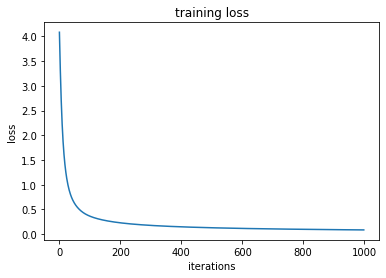

Test accuracy is 96.94444444444444%


In [ ]:
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****






































num_iters = 1000
lr = 0.1

# Loading dataset
# set up the code for this experiment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

%matplotlib inline
np.random.seed(1)

# load the digits dataset
digits = load_digits(n_class=10)

# partition the data
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, train_size=0.8, random_state=1)

# normalize features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# initialize W
num_feats = X_train[0].shape[0]
num_tests = y_test.shape[0]

W = np.random.rand(num_feats, 10)
losses = []

# updating W with gradient descent
for i in range(num_iters):
  loss, grad = cross_entropy_loss(X_train, W, y_train)
  losses.append(loss)
  W -= (grad * lr)

# plotting
plt.plot(range(num_iters), losses)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.title('training loss')
plt.show()

# testing
probs = MLR(X_test, W)
num_correct = 0
for i in range(num_tests):
  y_pred = np.argmax(probs[i])
  if y_pred == y_test[i]:
    num_correct += 1
print(f"Test accuracy is {num_correct / num_tests * 100}%")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Porblem 2: Decision Tree {-}

Decision trees are among the most powerful Machine Learning tools available today and are used in a wide variety of real-world applications. They are intuitive and easy to interpret. The final decision tree can explain exactly why a specific prediction was made, making it very attractive for operational use. In this section, we will explore how to implement a decision tree from scratch. 

The dataset we will use for this problem is the `Banknote` dataset. The task is to predict whether a banknote is authentic given a number of measures taken from a photograph. It is a binary classification problem. The dataset is stored in `data_banknote_authentication.csv` file, which contains 1372 samples(rows), 5 features (column 1-5) for each sample, and the last column (column 6) is the corresponding label.

## 2.1 Implementing decision tree from scratch {-}

In this lab, we only consider decision trees represented as a *binary* tree, i.e., each node can have 

1. no child, i.e., being a terminal node, 
2. two children that are both terminal nodes;
3. one child being a terminal node and the other being an internal node (i.e., has its own children);
4. two children which are both internal nodes.

In general, it is possible to allow three or more children, but for simplicity, this lab only considers two children.

A node represents a single input feature (attribute) and a split value on that feature, assuming the feature is numeric. The leaf nodes (we will call them as terminal nodes) contain an output class (0 or 1) which is used to make a prediction.
Once created, a tree can be navigated for a new example by following the branching criteria in each internal node, until reaching a final prediction.

Creating a binary decision tree is actually a process of dividing up the input space. A greedy approach is recursive binary splitting, where all the features and different split thresholds are tried using a cost function.
The split with the best cost (lowest cost because we minimize cost) is selected. **All input features and all possible split thresholds are evaluated, and the combination of (feature, threshold) that minimizes the cost is chosen.** Then the dataset is divided into two subsets, and the same selection procedure is used in each of the two subsets, hence called **greedy**.

Note we say "threshold" because all the features in the `banknote` dataset are numeric (i.e., continuously valued). When a feature is discrete, splitting can be done based on dividing all possible values into two categories, e.g.,
{apple, orange} for the left, and {banana, kiwi, peach} for the right.

In this lab, the **Gini cost function** is used which indicates how *pure* a node is.  A node's purity refers to the diversity of labels among all the training examples belonging to the node.
Splitting continues until the number of training examples in a node falls below a threshold or **a maximum tree depth** is reached.



### 2.1.1 Gini index (**7 points**) {-}

This lab will use the Gini index as the cost function to evaluate splits.
Every step of node construction requires splitting a datalist (a subset of training examples), which is based on one input feature and one value for that feature as the splitting threshold. It can be used to divide training examples into two groups of examples.  In particular, examples whose feature value is less than the threshold form the left group, and the rest examples form the right group.   

A Gini score gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. A perfect separation results in a Gini score of 0, where each group contains only one class of examples.
In contrast, the worst case is when each group contains 50/50% of both classes, leading to a Gini score of 0.5 (for a 2 class problem). 
Assume we have $m$ groups of data after splitting ($m=2$ in this lab). The Gini index for group $j$ ($j = 1$ or $2$) can be expressed as follows:

\begin{equation}
g_j = 1-\sum_{i=1}^nP_{ij}^2
\end{equation}
where $P_{ij}$ is the probability of a sample being classified to class $i$. Specifically, it can be computed by counting:

\begin{equation}
P_{ij} = \frac{\text{# examples of class i in group j}}{\text{# examples in group j}}
\end{equation}
The final Gini score can then be computed by weighted sum over all groups' Gini indices.

\begin{equation}
G = \sum_{j=1}^m w_jg_j, \quad \text{where} \quad
w_j = \frac{\text{# examples in group j}}{\text{# examples in the datalist}}.
\end{equation}
To better demonstrate the formula, let's go through an example step by step.
Assume we have split the data into 2 groups:

Group 1 contains **3** samples: **2** positive and **1** negative. \\
Group 2 contains **4** samples: **2** positive and **2** negative. \\
Then we can compute the Gini index for each group:
\begin{equation}
g_1 = 1-\left[(\frac{1}{3})^2 + (\frac{2}{3})^2\right] = \frac{4}{9} \\
g_2 = 1-\left[(\frac{1}{2})^2 + (\frac{1}{2})^2\right] = \frac{1}{2}
\end{equation}
The final Gini score can be computed by :
\begin{equation}
G = \frac{3}{7}\times g_1 + \frac{4}{7}\times g_2 = \frac{10}{21}
\end{equation}

In the following code block, impelment a function `gini_score` to compute the Gini score of two given groups. 

In [ ]:
def gini_score(groups, classes):
  '''
  Inputs: 
  groups: 2 lists of examples. 
  Each example is a list, where the last element is the label.
  classes: a list of different class labels (it's simply [0.0, 1.0] in this problem)
  Outputs:
  gini: gini score, a real number
  '''
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  gini = 0
  numbGroup = np.shape(groups)[0]
  numbClass = np.shape(classes)[0]
  labelvsGroupMatrix = np.zeros((numbGroup,numbClass))
  totalEx = 0
  numbExVec = np.zeros(numbGroup)
   # Count number of ex in the class
  for i in range (numbGroup):
    numbExVec[i] = np.shape(groups[i])[0]
    totalEx += numbExVec[i]
    for j in range (int(numbExVec[i])):
      value = int(groups[i][j][-1])
      labelvsGroupMatrix[i][value] += 1 # Count the freq of the values

  # sum weighted Gini index for each group
  gVector = np.zeros(numbClass)
  for i in range (numbClass):
    numbEx = numbExVec[i]
    # Calculate g
    if(numbEx == 0): # if group is empty
      gVector[i] = float("NaN")
    else:
      gVector[i] = (numbEx/totalEx)*(1 - ((labelvsGroupMatrix[i][0]/numbEx)**2 + (labelvsGroupMatrix[i][1]/numbEx)**2))
  # Calculate the gini
  gini = sum(gVector)

  # Cover the case one group is empty but the other group have output of one label
  
  if ((len(np.where(gVector == 0)[0]) == 1) and (np.isnan(gini))):
    gini = 0

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return gini


# unit test:
group1 = [[4.8, 3.1, 1],
[5.4, 3.4, 1],
[7.0, 3.2, 0],
[6.4, 3.2, 0]]
group2 = [[6.0, 3.0, 1],
[5.0, 3.4, 1],
[5.2, 3.5, 1]]
classes = [0, 1]
result = gini_score((group1, group2), classes)
print(result)


'''
should print: 0.2857142857142857
'''

0.2857142857142857


'\nshould print: 0.2857142857142857\n'

### 2.1.2 Create split (**3 points**) {-}

Splitting a dataset means dividing a dataset into two lists of examples given  a feature and a splitting threshold for that feature.
Once we have the two groups, we can then use the above Gini score function to evaluate the cost of the split.
Splitting a dataset involves iterating over all examples, checking if its feature value is below or above the split threshold, and assigning the example to the left or right group respectively.

In the following code block, implement a function `create_split`, which splits the given data list into two groups (left and right) for a given feature index and split threshold.  **Each `group` is nothing but a list of examples**. 

In [ ]:
def create_split(index, threshold, datalist):
  '''
  Inputs:
  index: The index of the feature used to split data. It starts from 0.
  threshold: The threshold for the given feature based on which to split the data.
        If an example's feature value is < threshold, then it goes to the left group.
        Otherwise (>= threshold), it goes to the right group.
  datalist: A list of samples. 
  Outputs:
  left: List of samples
  right: List of samples
  '''
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  left = []
  right = []
  # split the data
  for x in datalist:
    if (x[index]<threshold):
      left.append(x)
    else:
      right.append(x)
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return left, right


# unit test:
index = 1
threshold = 3.4
datalist = [[4.8, 3.1, 1.6, 1],
[5.4, 3.4, 1.5, 1],
[7.0, 3.2, 4.7, 0],
[6.4, 3.6, 2.7, 0]]
result = create_split(index, threshold, datalist)
print(result)


'''
should print: ([[4.8, 3.1, 1.6, 1], [7.0, 3.2, 4.7, 0]], [[5.4, 3.4, 1.5, 1], [6.4, 3.6, 2.7, 0]])
'''

([[4.8, 3.1, 1.6, 1], [7.0, 3.2, 4.7, 0]], [[5.4, 3.4, 1.5, 1], [6.4, 3.6, 2.7, 0]])


'\nshould print: ([[4.8, 3.1, 1.6, 1], [7.0, 3.2, 4.7, 0]], [[5.4, 3.4, 1.5, 1], [6.4, 3.6, 2.7, 0]])\n'

### 2.1.3 Find the best split (**6 points**){-}

With the above `gini_score` and `create_split` functions, we now have everything needed to evaluate the splits.

Given a list of data, we must check **every feature and every possible value of the feature in the datalist** as a candidate split, evaluate the cost of the split, and find the best possible split. Here we use the Gini index as the cost, and a lower value is better. Once the best split is found, we can use it as a node in our decision tree.

**As an important note on the terminology**, both `internal node` and `terminal node` are collectively referred to as `node`, and are hence both subject to the maximum depth constraint.
Both of them are different from `group`, which is just a list of examples.

A terminal node will be directly represented by a class value (e.g., 0 or 1 as a floating point, or depending on how the dataset represents its labels).

An internal/non-terminal node is represented by a dictionary of five fields:

1. `index`: the index of the feature selected to split the node into two groups;

2. `value`: the threshold of the feature by which the node is split;

3. `groups`: the result of `create_split`, which encodes the left and right groups.  By running "left_g, right_g = node['groups']", one can retrieve the two groups.  Each group of data is its own small data list of just those examples assigned to the left or right group by the splitting process. 

4. `left`: a node that represents the left child.  It can be either a terminal node or an internal node.

5. `right`: analogous to `left`.

In the following code block, implement a function `get_best_split` to find the best split for the given data list. 
Return a dictionary (i.e., an internal node) whose `index`, `value`, and `groups` are populated, i.e., storing the index of the chosen feature, the chosen splitting threshold, and the resulting two groups.
Leave `left` and `right` unspecified. 

In [ ]:
def get_best_split(datalist):
  '''
  Inputs:
  datalist: A list of samples. Each sample is a list, the last element is the label.
  Outputs:
  node: A dictionary contains 3 key value pairs, such as: node = {'index': integer, 'value': float, 'groups': a tuple contains two lists of examples}
  Pseudo-code:
  for index in range(#feature): # index is the feature index
    for example in datalist:
      use create_split with (index, example[index]) to divide datalist into two groups
      compute the Gini index for this division
  construct a node with the (index, example[index], groups) that corresponds to the lowest Gini index
  '''
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  featureNumb = np.shape(datalist)[1] - 1
  node = {}
  minIndex = 0
  minThreshold = 0
  minGini = 0.5
  classes = [0,1]
  minsplit = []

  # Find the best split
  for index in range(featureNumb): # index is the feature index
    for example in datalist:
      split = create_split(index, example[index], datalist)
      giniScore = gini_score(split, classes)
      if (minGini > giniScore):
        minGini = giniScore
        minIndex = index
        minThreshold = example[index]
        minsplit = split
  # construct a node with the (index, example[index], groups) that corresponds to the lowest Gini index
  node = {
      "index": minIndex,
      "value": minThreshold,
      "groups": minsplit
  }
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return node



# unit test:
datalist = [[4.8, 3.1, 1.6, 0.3, 1],
[5.4, 3.4, 1.5, 1.4, 1],
[7.0, 3.2, 4.7, 1.4, 0],
[6.4, 3.2, 2.7, 1.5, 0]]
result = get_best_split(datalist)
print(result)


'''
should print: 
{'index': 0, 
 'value': 6.4, 
 'groups': ([[4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1]], [[7.0, 3.2, 4.7, 1.4, 0], [6.4, 3.2, 2.7, 1.5, 0]])}
'''

{'index': 0, 'value': 6.4, 'groups': ([[4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1]], [[7.0, 3.2, 4.7, 1.4, 0], [6.4, 3.2, 2.7, 1.5, 0]])}


"\nshould print: \n{'index': 0, \n 'value': 6.4, \n 'groups': ([[4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1]], [[7.0, 3.2, 4.7, 1.4, 0], [6.4, 3.2, 2.7, 1.5, 0]])}\n"

### 2.1.4 Build a tree {-}

The construction of a decision tree consists of three major components:

1. Recursive splitting.

2. Termination condition of recursion: when to stop splitting

3. Building a tree.

**Step 1: termination function**

For simplicity, we will start with the termination condition, and then move on to the recursion.  Two hyperparamters are important here:

*   **Maximum Tree Depth**. This is the maximum number of predecessors (parent, grandparent, etc) that each node (terminal or internal/non-terminal) can have.  Once the maximum depth of the tree is met, we must stop splitting a node. Deeper trees are more complex and are more likely to overfit the training data.  Note we call the root node to have depth 1 (not 0), its child nodes with depth 2, and so on.

*   **Minimum Node Size**. This is the minimum number of training examples that a node can contain. If a node is split into two groups and one of them falls below this minimum size, then we should stop splitting that group further, i.e., we should make that group a terminal node.  Nodes that account for too few training examples are expected to be too specific and are likely to overfit the training data.

These two parameters will be specified by the user as input arguments of our tree building procedure.
There is one more situation. It is possible that a split is chosen where all examples belong to one group, while the other group is empty. In this case, we will be unable to continue the splitting and should stop.
Overall, there are 3 different **stopping conditions** which are clearly illustrated by the following pseudo-code (see the detailed explanations below).  



In [ ]:
# N = result
# left_g, right_g = N['groups']
# left_g = np.array(left_g)
# print(len(left_g))

# if ((len(left_g)==0) or (len(right_g)==0)):
#     #Set both N['left'] and N['right'] to a terminal node encoding the most common label of the examples in N
#     group = np.array(N['groups'])
#     label = group[:,:,-1]
#     values, counts = np.unique(label, return_counts=True) 
#     N['left'], N['right'] = values[label.index(np.argmax(counts))]
#     return
 
# # check for max depth
# if depth of N >= max_depth - 1:   # use >= instead of == in case max_depth = 1
#     N['left'] = a terminal node encoding the most common label in left_g
#     N['right'] = a terminal node encoding the most common label in right_g
#     return
 
# # process left child
# if the number of examples in left_g <= min_size:
#     N['left'] = a terminal node encoding the most common label of in left_g
# else:
#     N['left'] = get_best_split(left_g)
#     build a tree on N['left'] (use recursion)
 
# process right child similarly

Here N is the current node which is represented by a dictionary specified in Section 2.1.3.  The best split has already been found for N using `get_best_split`, and the fields `index`, `value`, and `groups` have already been computed for N (but not yet for `left` and `right`). Note that upon the completion of running the pseudo-code, the fields `left` and `right` of N will have been populated, which correspond to the left and right child nodes, respectively.

Note that we check "if either left_g or right_g is empty" before checking the max depth, because if either the left or the right group is empty, then N will become a terminal node returning its majority class, hence must satisfy the depth check. However, since we are already "inside" of N, we cannot change it into a terminal node per se; turning N into a terminal node can only be accomplished by N's own parent node (see the recursion in Step 2 below). As a result, we introduced a trick of adding a left child and a right child for N, both being a terminal node returning the majority class of N.  Strictly speaking, it is possible that the depth of N is already `max_depth`, which makes the left and right child nodes exceeding `max_depth`.  However, since this is just a workaround to represent that N is a terminal node, it does not make any difference in learning and prediction.

In the following code block, implement a function `to_terminal` that returns the most common class value in a group.  This will be used to make predictions. (**4 points)**

In [ ]:
def to_terminal(group):
  '''
  Input:
    group: A list of examples. Each example is a list, whose last element is the label.
  Output:
    label: the label indicating the most common class value in the group
  '''
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  group = np.array(group)
  label = group[:,-1]
  values, counts = np.unique(label, return_counts=True) 
  label = values[np.where(counts == counts.max())]
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return label


# unit test:
group = [[4.8, 3.1, 1],
[5.4, 3.4, 1],
[7.0, 3.2, 0]]
result = to_terminal(group)
print(result)


'''
should print: 1
'''

[1.]


'\nshould print: 1\n'

**Step 2: Recursive splitting**  (**15 points**)

Building a decision tree involves calling the above functions `get_best_split` and `to_terminal` over and over again on the groups created for each node.
Once a node is constructed, we can construct its child nodes recursively on each group of data from the split by calling the same node construction function again.

In the following code block, implement a function `recursive_split` to conduct this recursive procedure. It takes a `node` as an argument as well as the maximum depth, minimum size in a node and the depth of `node`.
Before invoking `recursive_split`, three key-value pairs `index`, `value`, and `groups` have already been computed for `node` using `get_best_split`, i.e., the best split has already been found and stored. 

In fact, all you need to do is to implement the pseudo-code in "Step 1: termination function". 
Here is the step-by-step explanation:

1.   The two groups of data carried by the given `node` are extracted as left and right data lists for use. Then delete the `groups` field in `node` to save space because it will not be needed any more. This deletion is not reflected in the pseudo-code, and you need to implement it.

2.   Next, we check if either the left group (`left_g`) or the right group (`right_g`) is empty.  If so, create a terminal node for both left and right groups by applying `to_terminal` on the non-empty group.  Yes, even for the empty group, we also adopt the result of `to_terminal` on the (other) non-empty group.  Think why.

3.   We then check the depth. If `max_depth` is reached by the child node (i.e., the depth of `node` itself has reached `max_depth`-1), then  create terminal nodes for both the left and the right groups using `to_terminal`.

4.   Then we process the left child.  If the left group's size is below `min_size`, then create a terminal node for it using `to_terminal`. Otherwise, create a split for the left group by `get_best_split`, and assign the resulting node to the `left` field of `node`. Then pass `node[left]` to the `recursive_split` function with 1 + the depth of `node`.

5.   The right child is then processed in the same manner.

In [ ]:
# Create child splits for a node or make terminal
def recursive_split(node, max_depth, min_size, depth):
  '''
  Inputs:
  node:  A dictionary contains 3 key value pairs, node = 
         {'index': integer, 'value': float, 'groups': a tuple contains two lists fo samples}
  max_depth: maximum depth of the tree, an integer
  min_size: minimum size of a group, an integer
  depth: tree depth for current node
  Output:
  no need to output anything, the input node should carry its own subtree once this function ternimate
  '''
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  left_g, right_g = np.array(node['groups'])
  # check for a no split
  if (len(left_g)==0): # either left_g or right_g is empty
    node['left'] = to_terminal(right_g)
    node['right'] = to_terminal(right_g)
    return 
  if (len(right_g)==0): # either left_g or right_g is empty
    node['left'] = to_terminal(left_g)
    node['right'] = to_terminal(left_g)
    return 
  # check for max depth
  if (depth >= max_depth - 1): # use >= instead of == in case max_dep th = 1
    node['left'] = to_terminal(left_g)
    node['right'] = to_terminal(right_g)
    return
  # process left child
  if (((np.array(left_g)).shape[0]) < min_size):
    node['left'] = to_terminal(left_g)
  else:
    node['left'] = get_best_split(left_g)
    recursive_split(node['left'], max_depth, min_size, depth+1)
  # process right child
  if (((np.array(right_g)).shape[0]) < min_size):
    node['right'] = to_terminal(right_g)
  else:
    node['right'] = get_best_split(right_g)
    recursive_split(node['right'], max_depth, min_size, depth+1)

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


node = {'index': 2, 'value': 2.6, 
        'groups': ([[4.8, 3.4, 1.9, 0.2, 1], 
                    [6.0, 3.0, 1.6, 1.2, 1], 
                    [5.2, 3.5, 1.5, 0.6, 1], 
                    [4.8, 3.1, 1.6, 0.3, 1], 
                    [5.4, 3.4, 1.5, 1.4, 1], 
                    [4.3, 3.5, 1.6, 0.6, 0]], 
                   [[5.0, 3.4, 4.6, 1.9, 1], 
                    [5.2, 3.4, 3.4, 1.5, 1], 
                    [8.7, 3.2, 5.6, 0.2, 1], 
                    [7.0, 3.2, 4.7, 1.4, 0], 
                    [6.4, 3.2, 2.7, 1.5, 0], 
                    [4.9, 3.1, 4.9, 1.5, 0], 
                    [4.5, 2.3, 4.0, 0.3, 0], 
                    [6.5, 2.8, 2.6, 1.5, 0], 
                    [5.7, 3.8, 4.5, 1.3, 0], 
                    [4.9, 2.4, 3.3, 1.0, 0]])}
max_depth = 4
min_size = 3
depth = 1
recursive_split(node, max_depth, min_size, depth)
print(node)


'''
# should print:
{'index': 2, 
 'value': 2.6, 
 'left': {'index': 0, 
          'value': 4.8, 
          'left': 0, 
          'right': {'index': 0, 
                    'value': 4.8, 
                    'left': 1, 
                    'right': 1}}, 
  'right': {'index': 1, 
            'value': 3.2, 
            'left': {'index': 0, 
                     'value': 4.9, 
                     'left': 0, 
                     'right': 0}, 
            'right': {'index': 0, 
                      'value': 5.7, 
                      'left': 1, 
                      'right': 0}}}
'''

{'index': 2, 'value': 2.6, 'groups': ([[4.8, 3.4, 1.9, 0.2, 1], [6.0, 3.0, 1.6, 1.2, 1], [5.2, 3.5, 1.5, 0.6, 1], [4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1], [4.3, 3.5, 1.6, 0.6, 0]], [[5.0, 3.4, 4.6, 1.9, 1], [5.2, 3.4, 3.4, 1.5, 1], [8.7, 3.2, 5.6, 0.2, 1], [7.0, 3.2, 4.7, 1.4, 0], [6.4, 3.2, 2.7, 1.5, 0], [4.9, 3.1, 4.9, 1.5, 0], [4.5, 2.3, 4.0, 0.3, 0], [6.5, 2.8, 2.6, 1.5, 0], [5.7, 3.8, 4.5, 1.3, 0], [4.9, 2.4, 3.3, 1.0, 0]]), 'left': {'index': 0, 'value': 4.8, 'groups': ([[4.3, 3.5, 1.6, 0.6, 0]], [[4.8, 3.4, 1.9, 0.2, 1], [6.0, 3.0, 1.6, 1.2, 1], [5.2, 3.5, 1.5, 0.6, 1], [4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1]]), 'left': array([0.]), 'right': {'index': 0, 'value': 4.8, 'groups': ([], [[4.8, 3.4, 1.9, 0.2, 1], [6.0, 3.0, 1.6, 1.2, 1], [5.2, 3.5, 1.5, 0.6, 1], [4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1]]), 'left': array([1.]), 'right': array([1.])}}, 'right': {'index': 1, 'value': 3.2, 'groups': ([[4.9, 3.1, 4.9, 1.5, 0], [4.5, 2.3, 4.0, 0.3, 0], [6.5, 2.8, 2.

"\n# should print:\n{'index': 2, \n 'value': 2.6, \n 'left': {'index': 0, \n          'value': 4.8, \n          'left': 0, \n          'right': {'index': 0, \n                    'value': 4.8, \n                    'left': 1, \n                    'right': 1}}, \n  'right': {'index': 1, \n            'value': 3.2, \n            'left': {'index': 0, \n                     'value': 4.9, \n                     'left': 0, \n                     'right': 0}, \n            'right': {'index': 0, \n                      'value': 5.7, \n                      'left': 1, \n                      'right': 0}}}\n"

**Step 3: Build a tree** (**3 points**)

We can now put all of the pieces together.
In the following code block, implement a function `build_tree` to build a decision tree by the given training set, maximum depth, minimum size.
We first create the root node by calling `get_best_split`. 
Then call `recursive_split` to build out the tree with the current depth set to 1.
Upon completion of `recursive_split`, the root node should carry the whole tree.

In [ ]:
def build_tree(train, max_depth, min_size):
  '''
  Inputs:
    - train: Training set, a list of examples. Each example is a list, whose last element is the label.
    - max_depth: maximum depth of the tree, an integer (root has depth 1)
    - min_size: minimum size of a group, an integer
  Output:
    - root: The root node, a recursive dictionary that should carry the whole tree
  '''
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  root = get_best_split(train)
  depth = 1
  recursive_split(root, max_depth, min_size, depth)
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return root


# unit test:
train = [[4.8, 3.4, 1.9, 0.2, 1],
[6.0, 3.0, 1.6, 1.2, 1],
[5.0, 3.4, 4.6,	1.9, 1],
[5.2, 3.5, 1.5, 0.6, 1],
[5.2, 3.4, 3.4, 1.5, 1],
[8.7, 3.2, 5.6,	0.2, 1],
[4.8, 3.1, 1.6, 0.3, 1],
[5.4, 3.4, 1.5, 1.4, 1],
[7.0, 3.2, 4.7, 1.4, 0],
[6.4, 3.2, 2.7, 1.5, 0],
[4.9, 3.1, 4.9, 1.5, 0],
[4.5, 2.3, 4.0, 0.3, 0],
[6.5, 2.8, 2.6, 1.5, 0],
[5.7, 3.8, 4.5, 1.3, 0],
[4.3, 3.5, 1.6, 0.6, 0],
[4.9, 2.4, 3.3, 1.0, 0]]
max_depth = 4
min_size = 3
root = build_tree(train, max_depth, min_size)
print(root)


'''
should print: 
{'index': 2, 
 'value': 2.6, 
 'left': {'index': 0, 
          'value': 4.8, 
          'left': 0, 
          'right': {'index': 0, 
                    'value': 4.8, 
                    'left': 1, 
                    'right': 1}}, 
 'right': {'index': 1, 
           'value': 3.2, 
           'left': {'index': 0, 
                    'value': 4.9, 
                    'left': 0, 
                    'right': 0}, 
           'right': {'index': 0, 
                     'value': 5.7, 
                     'left': 1, 
                     'right': 0}}}
'''

{'index': 2, 'value': 2.6, 'groups': ([[4.8, 3.4, 1.9, 0.2, 1], [6.0, 3.0, 1.6, 1.2, 1], [5.2, 3.5, 1.5, 0.6, 1], [4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1], [4.3, 3.5, 1.6, 0.6, 0]], [[5.0, 3.4, 4.6, 1.9, 1], [5.2, 3.4, 3.4, 1.5, 1], [8.7, 3.2, 5.6, 0.2, 1], [7.0, 3.2, 4.7, 1.4, 0], [6.4, 3.2, 2.7, 1.5, 0], [4.9, 3.1, 4.9, 1.5, 0], [4.5, 2.3, 4.0, 0.3, 0], [6.5, 2.8, 2.6, 1.5, 0], [5.7, 3.8, 4.5, 1.3, 0], [4.9, 2.4, 3.3, 1.0, 0]]), 'left': {'index': 0, 'value': 4.8, 'groups': ([[4.3, 3.5, 1.6, 0.6, 0]], [[4.8, 3.4, 1.9, 0.2, 1], [6.0, 3.0, 1.6, 1.2, 1], [5.2, 3.5, 1.5, 0.6, 1], [4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1]]), 'left': array([0.]), 'right': {'index': 0, 'value': 4.8, 'groups': ([], [[4.8, 3.4, 1.9, 0.2, 1], [6.0, 3.0, 1.6, 1.2, 1], [5.2, 3.5, 1.5, 0.6, 1], [4.8, 3.1, 1.6, 0.3, 1], [5.4, 3.4, 1.5, 1.4, 1]]), 'left': array([1.]), 'right': array([1.])}}, 'right': {'index': 1, 'value': 3.2, 'groups': ([[4.9, 3.1, 4.9, 1.5, 0], [4.5, 2.3, 4.0, 0.3, 0], [6.5, 2.8, 2.

"\nshould print: \n{'index': 2, \n 'value': 2.6, \n 'left': {'index': 0, \n          'value': 4.8, \n          'left': 0, \n          'right': {'index': 0, \n                    'value': 4.8, \n                    'left': 1, \n                    'right': 1}}, \n 'right': {'index': 1, \n           'value': 3.2, \n           'left': {'index': 0, \n                    'value': 4.9, \n                    'left': 0, \n                    'right': 0}, \n           'right': {'index': 0, \n                     'value': 5.7, \n                     'left': 1, \n                     'right': 0}}}\n"

### 2.1.5 Prediction (**6 points**){-}

To make predictions with a decision tree, we need to navigate the tree for each test example.

In the following code block, implement a function `predict` to predict the  label for all test examples.
For each test example, the navigation of the tree can be implemented by using a while loop, or as a recursive function where the same prediction routine is called recursively based on the `index` and `value` fields of the internal nodes, until a terminal node is reached. 

In the function, we need to check if a child node is a terminal value (class label to be returned as the prediction), or an internal node that is represented as a dictionary. You may find the function [isinstance](https://www.w3schools.com/python/ref_func_isinstance.asp) useful.

In [ ]:
# Make a prediction with a decision tree
def predict(root, sample):
  '''
  Inputs:
  root: the root node of the tree. a recursive dictionary that carries the whole tree.
  sample: a list
  Outputs:
  '''
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  while (isinstance(root, dict)):
    if (sample[root['index']]< root['value']):
        root = root['left']
    else:
      root = root['right']
  return root
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# unit test:
root = {'index': 2, 'value': 2.6, 'left': {'index': 0, 'value': 4.8, 'left': 0, 'right': 1}, 'right': 1}
sample1 = [5.4, 3.4, 1.5, 1.4]
sample2 = [4.3, 3.5, 1.6, 0.6]
print(predict(root, sample1))
print(predict(root, sample2))

'''
should print: 
1
0
'''

1
0


'\nshould print: \n1\n0\n'

## 2.2 Training and testing (**6 points**) {-}

Now we are ready to apply this algorithm to the `Banknote` dataset. In the following code block, evaluate the decision tree model as follow:

*   Load the dataset to a list of examples (already done)
*   Since the loaded data features are of string type, covert all features to float type
*   Split the dataset into a training set and a test set. Use the first 1000 samples for training, and the rest for testing.
*   Build a tree by providing the traning set, maximum depth and minimum size.
*   Make prediction for all test examples using the built tree.
*   Print the accuracy and f1 score for the test set.

In [ ]:
# load and prepare data
import pandas as pd
import urllib.request
import shutil
from csv import reader
from random import seed

url = 'https://www.cs.uic.edu/~zhangx/teaching/data_banknote_authentication.csv'
file_name = 'data_banknote_authentication.csv'
with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

file = open(file_name, "rt")
lines = reader(file)

df = pd.read_csv(file_name,
                    sep='\t',
                    header=None)
df.head()

,0
0,"3.6216,8.6661,-2.8073,-0.44699,0"
1,"4.5459,8.1674,-2.4586,-1.4621,0"
2,"3.866,-2.6383,1.9242,0.10645,0"
3,"3.4566,9.5228,-4.0112,-3.5944,0"
4,"0.32924,-4.4552,4.5718,-0.9888,0"


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
seed(1)

dataset = list(lines)
max_depth = 6
min_size = 10
num_train = 1000

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# convert string attributes to float
numbExample = len(dataset)
numbFeature = len(dataset[0])
data = np.zeros((numbExample, numbFeature))
training_set = np.zeros((numbExample, numbFeature))
test_set = np.zeros((numbExample - num_train, numbFeature))
# Convert 
for i in range(numbExample):
  for j in range(numbFeature):
    data[i][j] = float(dataset[i][j])
  
#create the training and test set
training_set = np.zeros((numbExample, numbFeature))
test_set = np.zeros((numbExample - num_train, numbFeature))
# Extract the data into taining or testing set
training_set = data[0:num_train][:]
test_set = data[num_train :][:]

# Create the tree
root = get_best_split(training_set)
depth = 1
recursive_split(root, max_depth, min_size, depth)

# Predict
num_tests = numbExample - num_train
predicted_label = np.zeros(num_tests)
true_label = test_set[:, -1]

for i in range (num_tests):
  predicted_label[i] = predict(root, test_set[i][0:-1])

# evaluate algorithm
# Accuracy 
print(accuracy_score(true_label, predicted_label))
# f score
print(f1_score(true_label, predicted_label))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

0.9543010752688172
0.9766162310866575


# Submission Instruction {-}

You're almost done! Take the following steps to finally submit your work.

1. After executing all commands and completing this notebook, save your `Lab_3.ipynb` as a PDF file, named as `X_Y_UIN.pdf`, where `X` is your first name, `Y` is your last name, and `UIN` is your UIN. Make sure that your PDF file includes all parts of your solution, including the plots. 

> * Print out all unit test case results before printing the notebook into a PDF.
* If you use Colab, open this notebook in Chrome.  Then File -> Print -> set Destination to "Save as PDF".  If the web page freezes when printing, close Chrome and reopen the page. If Chrome doesn't work, try Firefox.
* If you are working on your own computer, we recommend using the browser (not jupyter) for saving the PDF. For Chrome on a Mac, this is under *File->Print...->Open PDF in Preview*. When the PDF opens in Preview, you can use *Save...* to save it.
* Sometimes, a figure that appears near the end of a page can get cut.  In this case, try to add some new lines in the preceding code block so that the figure is pushed to the beginning of the next page.

2. Upload `X_Y_UIN.pdf` to Gradescope under `Lab_3_Written`.

3. A template of `Lab_3.py` has been provided.  For all functions in `Lab_3.py`, copy the corresponding code snippets you have written into it.  Do not copy any code of plotting figures. **Do NOT** change the function names.

4. Zip `Lab_3.py` and `Lab_3.ipynb` (**2 files**) into a zip file named `X_Y_UIN.zip`. Suppose the two files are in the folder `Lab_3`.  Then zip up the two files inside the `Lab_3` folder.  Do NOT zip up the folder `Lab_3`. Submit this zip file to Gradescope under `Lab_3_Code`. 

5. The autograder on Gradscope will be open all the time. We designed some simple test cases to help you check wehther your functions are execuable. You will see the results of running autogrder once you submit your code. If you see 'test `function_name` completed', it means your function is execuable; otherwise please follow the error messages to debug. Since those simple test cases are designed for debugging, it does not guaranttee your solution will work well on the real dataset. It is your responsibility to make your code logically correct.

6. Only one member of each team needs to submit.  But please specify **all** your teammates on Gradescope. After each submission, please click 'Add Group Member' (top-right corner of your submission page) to claim all teammates.

You can submit to Gradescope as often as you like. We will only consider your last submission before the deadline.